In [16]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [17]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM

In [18]:
geo = pd.read_csv('../data/daks_processed_with_rf.csv')
geo.head(10)
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [19]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Depositional environment': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont',
 'Oil density': 'cont',
 'Oil recovery factor': 'cont'}

In [20]:
geo_signs = get_nodes_sign(geo)
geo_signs

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos',
 'Oil density': 'pos',
 'Oil recovery factor': 'pos'}

In [21]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [22]:
geo_coded, label_coder = code_categories(geo, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', columns_for_disc)

<AxesSubplot:xlabel='Period'>

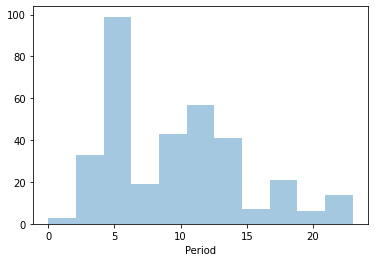

In [15]:
sns.distplot(geo_coded['Period'], kde=False)

In [23]:
bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'K2')

  0%|          | 20/1000000 [00:12<172:26:27,  1.61it/s]


In [24]:
params = parameter_learning(geo, geo_types, bn_full, 'simple')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [25]:
sample = generate_synthetics(all_bn, geo_signs, 'simple', 400)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Oil recovery factor', ylabel='Density'>

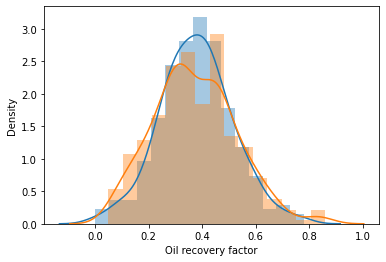

In [28]:
sns.distplot(sample['Oil recovery factor'])
sns.distplot(geo['Oil recovery factor'])

In [10]:
acc, rmse, real, pred = calculate_acc(all_bn, geo, columns, 'mix')

In [11]:
acc

{'Tectonic regime': 0.81,
 'Period': 0.35,
 'Lithology': 0.58,
 'Structural setting': 0.44,
 'Depositional environment': 0.21}

In [12]:
rmse

{'Gross': 440.5,
 'Netpay': 30.24,
 'Porosity': 5.71,
 'Permeability': 704.36,
 'Depth': 406.73,
 'Oil density': 14.51,
 'Oil recovery factor': 0.14}

In [13]:
params = parameter_learning(geo, geo_types, bn_full, 'simple')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [14]:
acc, rmse, real, pred = calculate_acc(all_bn, geo, columns, 'simple')

In [15]:
acc

{'Tectonic regime': 0.81,
 'Period': 0.34,
 'Lithology': 0.58,
 'Structural setting': 0.44,
 'Depositional environment': 0.23}

In [16]:
rmse

{'Gross': 483.91,
 'Netpay': 31.56,
 'Porosity': 5.71,
 'Permeability': 799.65,
 'Depth': 465.71,
 'Oil density': 21.7,
 'Oil recovery factor': 0.15}